In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
import os
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import cross_val_predict
import math
from quantile_forest import RandomForestQuantileRegressor

from benchmark_pipeline import read_features, quantile_cross_val_predict, calc_picp, calc_qcp

from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from scipy.optimize import minimize
import lightgbm as lgb

# df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/data/002_data_whole.csv',low_memory=False)
output_folder = '/mnt/primus/xuemeng_tmp_harbour/soc/results'

In [2]:
class QRPP_RF(BaseEstimator, RegressorMixin):
    def __init__(self, rf_model=None, rf_params=None, quantiles=[0.05, 0.95], n_jobs=90, nmodel = 'lgbm', refit=True):
        if rf_model is not None:
            self.rf_model = rf_model
            self.rf_params = rf_model.get_params()
        else:
            self.rf_params = rf_params if rf_params is not None else {}
            self.rf_params.update({'n_jobs': n_jobs})
            self.rf_model = RandomForestRegressor(**self.rf_params)
        
        self.quantiles = quantiles
        self.n_jobs = n_jobs
        self.refit = refit
        self.qr_models = {}
        common_params = {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'n_jobs': n_jobs, 'verbose':-1}
        for q in self.quantiles:
            self.qr_models[q] = lgb.LGBMRegressor(objective='quantile', alpha=q, **common_params)
        # common_params = {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'learning_rate': 0.1, 'loss': 'quantile'}
        # for q in self.quantiles:
        #     self.qr_models[q] = GradientBoostingRegressor(loss='quantile', alpha=q, **common_params)

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Fit the Random Forest model if not pre-fitted
        if self.refit:
            self.rf_model.fit(X, y)
        
        # Get point predictions
        point_predictions = self.rf_model.predict(X)
        
        # Fit LightGBM Regressors on the original data (X, y)
        for q in self.quantiles:
            self.qr_models[q].fit(X, y)
        
        self.is_fitted_ = True
        return self

    def predict(self, X, quantiles=None, return_point_predictions=False):
        # Check if fit has been called
        check_is_fitted(self, 'is_fitted_')
        
        # Input validation
        X = check_array(X)
        
        # Get point predictions
        point_predictions = self.rf_model.predict(X)
        
        # Predict quantiles
        if quantiles is None:
            quantiles = self.quantiles
        elif isinstance(quantiles, float):
            quantiles = [quantiles]
            
        predictions = np.zeros((X.shape[0], len(quantiles)))
        
        for i, q in enumerate(quantiles):
            predictions[:, i] = self.qr_models[q].predict(X)
        
        if return_point_predictions:
            return point_predictions, predictions
        else:
            return predictions

In [3]:
prop = 'oc'

# Find the p25 (Q1) and p75 (Q3) to calculate the interquartile range (IQR), 
# then use it to estimate the standard deviation (σ)
quantiles = [0.25,0.75]
cv = GroupKFold(n_splits=5)  
spatial_cv_column = 'tile_id'

test = pd.read_csv(f'{output_folder}/{prop}/benchmark_test.pnts_{prop}.csv',low_memory=False)
train = pd.read_csv(f'{output_folder}/{prop}/benchmark_train.pnts_{prop}.csv',low_memory=False)

covs = read_features(f'{output_folder}/{prop}/benchmark_selected.covs_{prop}.txt')

train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')

train['oc_log1p'] = np.log1p(train['oc'])
test['oc_log1p'] = np.log1p(test['oc'])

tgt = 'oc_log1p'


# for ipath in path_list:
#     if f'/{prop}/' in ipath:
#         file_rf = ipath

# file_rf = find_files('/mnt/primus/xuemeng_tmp_harbour/soc/results/production_model/',f'propduction.quantile.model_rf.{prop}*')
# file_rf = str(file_rf[0])
file_rf = '/mnt/primus/xuemeng_tmp_harbour/soc/results/oc/model_rf.oc_log1p.ccc.joblib'

rf_model = joblib.load(file_rf)
rf_model.n_jobs = 90
# rf_model.fit(train[covs], train[tgt])
params = rf_model.get_params()
print(params['n_jobs'])

90


In [7]:
results = []

ttprint(f'quantile, individual test, {tgt}, qrpp-rf')
qrpp_rf = QRPP_RF(rf_model, quantiles=quantiles, n_jobs=90, refit=True)
qrpp_rf.fit(train[covs], train[tgt])
start_time = time.time()
y_point_test, y_pred_test = qrpp_rf.predict(test[covs], return_point_predictions=True)
end_time = time.time()
test_time = (end_time - start_time)
picp_test = calc_picp(y_pred_test[:,0], y_pred_test[:,1], test[tgt])
qcp_test_lower = calc_qcp(y_pred_test[:,0], test[tgt], quantiles[0])
qcp_test_upper = calc_qcp(y_pred_test[:,1], test[tgt], quantiles[1])
piw_test = np.mean(y_pred_test[:,1]-y_pred_test[:,0])

std = (y_pred_test[:,1]-y_pred_test[:,0])/1.349 # calculate std from piw
dev_test = (y_point_test-test[tgt])/std
dev = np.mean(dev_test)

results.append({
    'property': tgt,
    'method': 'qrpp-rf, test',
    'picp': picp_test,
    'piw': piw_test,
    'qcp05': qcp_test_lower,
    'qcp95': qcp_test_upper,
    'deviation factor': dev,
    'time': test_time
})


ttprint(f'quantile, spatial CV test, {tgt}, qrpp-rf')
start_time = time.time()
y_point_cv, y_pred_cv = quantile_cross_val_predict(qrpp_rf, train[covs], train[tgt], cv, quantiles, groups=train[spatial_cv_column], return_point_predictions=True)
end_time = time.time()
cv_time = (end_time - start_time)


picp_cv = calc_picp(y_pred_cv[:,0], y_pred_cv[:,1], train[tgt])  
qcp_cv_lower = calc_qcp(y_pred_cv[:,0], train[tgt], quantiles[0])
qcp_cv_upper = calc_qcp(y_pred_cv[:,1], train[tgt], quantiles[1])  
piw_cv = np.mean(y_pred_cv[:,1]-y_pred_cv[:,0])

std = (y_pred_cv[:,1]-y_pred_cv[:,0])/1.349 # calculate std from piw
dev_cv = (y_point_cv-train[tgt])/std
dev = np.mean(dev_cv)

results.append({
    'property': tgt,
    'method': 'qrpp-rf, cv',
    'picp': picp_cv,
    'piw': piw_cv,
    'qcp05': qcp_cv_lower,
    'qcp95': qcp_cv_upper,
    'deviation factor': dev,
    'time': cv_time
})

results = pd.DataFrame(results)
results

[13:02:13] quantile, individual test, oc_log1p, qrpp-rf
[13:02:22] quantile, spatial CV test, oc_log1p, qrpp-rf


,property,method,picp,piw,qcp05,qcp95,deviation factor,time
0,oc_log1p,"qrpp-rf, test",0.495478,0.790993,0.247739,0.743216,0.003341,0.259227
1,oc_log1p,"qrpp-rf, cv",0.244771,0.822260,0.376049,0.620795,-0.240105,39.940944


<Axes: >

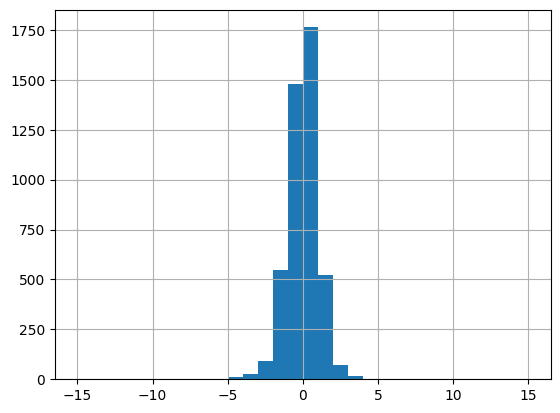

In [14]:
dev_test.hist(bins=30,range=[-15,15])

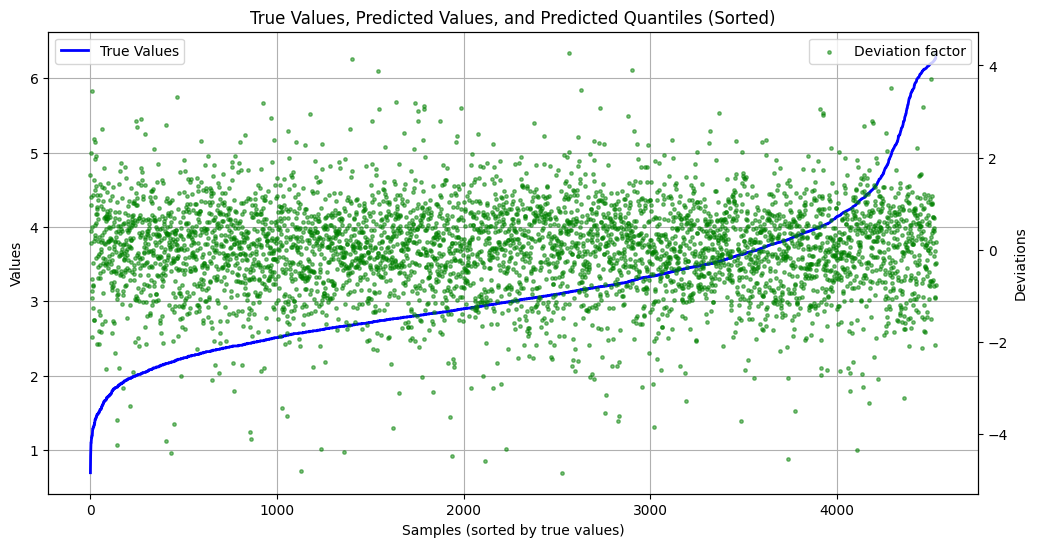

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_sorted_predictions(true_values, predicted_values, predicted_quantiles, quantiles, dev_factor):
    """
    Plot true values, predicted values, and predicted quantiles after sorting by true values.
    
    Parameters:
    - true_values: Array-like, true target values.
    - predicted_values: Array-like, predicted target values (point predictions).
    - predicted_quantiles: 2D Array-like, predicted quantiles with shape (n_samples, n_quantiles).
    - quantiles: List of quantiles corresponding to the columns of predicted_quantiles.
    """
    # Ensure inputs are numpy arrays for easier indexing and sorting
    true_values = np.array(true_values)
    predicted_values = np.array(predicted_values)
    predicted_quantiles = np.array(predicted_quantiles)

    # Get the indices that would sort the true values
    sorted_indices = np.argsort(true_values)
    
    # Sort all inputs by the sorted indices of true values
    sorted_true_values = true_values[sorted_indices]
    sorted_predicted_values = predicted_values[sorted_indices]
    sorted_predicted_quantiles = predicted_quantiles[sorted_indices]

    plt.figure(figsize=(12, 6))
    
#     # Fill the area between the quantiles
#     window_size = 30
#     lower_quantile = np.convolve(sorted_predicted_quantiles[:, 0], np.ones(window_size) / window_size, mode='same')
#     upper_quantile = np.convolve(sorted_predicted_quantiles[:, 1], np.ones(window_size) / window_size, mode='same')
#     plt.fill_between(range(len(sorted_true_values)), lower_quantile, upper_quantile, color='gray', alpha=0.3, label=f'Quantile Interval {quantiles[0]}-{quantiles[1]}')
    
#     # Plot predicted values as scatter plot
#     plt.scatter(range(len(sorted_true_values)), sorted_predicted_values, label='Predicted Values', color='red', alpha=0.5, s=6)
    
    # Plot true values
    plt.plot(sorted_true_values, label='True Values', color='blue', linewidth=2)
   
    plt.xlabel('Samples (sorted by true values)')
    plt.ylabel('Values')
    plt.title('True Values, Predicted Values, and Predicted Quantiles (Sorted)')
    plt.legend()
    plt.grid(True)
    
    ax2 = plt.gca().twinx()
    ax2.scatter(range(len(sorted_true_values)), dev_factor, label='Deviation factor', color='green', alpha=0.5, s=6)
    ax2.set_ylabel('Deviations')
    ax2.legend(loc='upper right')
    
    plt.show()

true_values = test[tgt]
predicted_values = y_point_test
predicted_quantiles = y_pred_test
quantiles = [0.05, 0.95]

plot_sorted_predictions(true_values, predicted_values, predicted_quantiles, quantiles,dev_test)
# from benchmark_pipeline import accuracy_plot
# accuracy_plot(true_values, predicted_values, 'test', '/mnt/primus/xuemeng_tmp_harbour/soc/results/SHAP', show_range=[0,8], vmax=5)

In [9]:
import scipy.stats as stats

# For 1 standard deviation (68.27%)
lower_1sigma = stats.norm.ppf(0.1587)
upper_1sigma = stats.norm.ppf(0.8413)

# For 2 standard deviations (95.45%)
lower_2sigma = stats.norm.ppf(0.0228)
upper_2sigma = stats.norm.ppf(0.9772)

# For 3 standard deviations (99.73%)
lower_3sigma = stats.norm.ppf(0.00135)
upper_3sigma = stats.norm.ppf(0.99865)

print("1σ bounds:", lower_1sigma, upper_1sigma)
print("2σ bounds:", lower_2sigma, upper_2sigma)
print("3σ bounds:", lower_3sigma, upper_3sigma)


1σ bounds: -0.9998150936147444 0.9998150936147446
2σ bounds: -1.99907721497177 1.9990772149717693
3σ bounds: -2.9999769927033935 2.9999769927034015


### compare 4 methods in quantifying uncertainty

In [3]:
# a = find_files('/mnt/primus/xuemeng_tmp_harbour/soc/results/', 'model_rf.*.ccc.joblib')
# a = [str(i) for i in a]
best_dfff = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/soc/results/benchmark_metrics_predictions.csv',low_memory=False)

prop_list = ['oc','ph_h2o','ph_cacl2','bulk_density','caco3','CEC','EC','P','K','N']
path_list = []
covs_list = []
for prop in prop_list:
    covs_list.append(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}/benchmark_selected.covs_{prop}.txt')
    
    a = find_files(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}/','*model*joblib')
    a = [str(i) for i in a]
    model_t = best_dfff.loc[best_dfff['property']==prop,'title'].values[0]
    
    if 'weighted' in model_t:
        model_t = model_t.split('_')[0]
        a = [ii for ii in a if 'weighted' in ii]
    else:
        a = [ii for ii in a if 'weighted' not in ii]

    for ia in a:
        if model_t in ia:
            path_list.append(ia)

In [4]:
path_list

['/mnt/primus/xuemeng_tmp_harbour/soc/results/oc/model_rf.oc_log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_h2o/model_rf.ph_h2o_normal.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_cacl2/model_rf.ph_cacl2_normal.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/bulk_density/model_rf.bulk_density_normal.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/caco3/model_rf.caco3_log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/CEC/model_rf.CEC_log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/EC/model_rf.EC_log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/P/model_rf.P_log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/K/model_rf.K_log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/N/model_rf.N_log1p.ccc.joblib']

In [22]:

from deel.puncc.api.prediction import BasePredictor
from deel.puncc.regression import SplitCP
from mapie.regression import MapieRegressor


quantiles = [0.05,0.95]
results = []
cv = GroupKFold(n_splits=5)  
spatial_cv_column = 'tile_id'

import warnings
warnings.filterwarnings('ignore', message="X has feature names, but RandomForestQuantileRegressor was fitted without feature names")

for prop in ['oc']: #prop_list:
    test = pd.read_csv(f'{output_folder}/{prop}/benchmark_test.pnts_{prop}.csv',low_memory=False)
    train = pd.read_csv(f'{output_folder}/{prop}/benchmark_train.pnts_{prop}.csv',low_memory=False)

    covs = read_features(f'{output_folder}/{prop}/benchmark_selected.covs_{prop}.txt')
    
    train = train.dropna(subset=covs,how='any')
    test = test.dropna(subset=covs,how='any')
    
    # for ipath in path_list:
    #     if f'/{prop}/' in ipath:
    #         file_rf = ipath
            
    file_rf = find_files('/mnt/primus/xuemeng_tmp_harbour/soc/results/production_model/',f'propduction.quantile.model_rf.{prop}*')
    file_rf = str(file_rf[0])
    
    rf_model = joblib.load(file_rf)
    rf_model.n_jobs = 90
    params = rf_model.get_params()
    print(params['n_jobs'])
    # params['n_jobs'] = 90
    qrf = RandomForestQuantileRegressor(**params)
    
    ttprint(f'quantile, cv, {prop}')
#     # cv valiadate
#     # y_pred_cv_rf = cross_val_predict(rf_model, train[covs], train[prop], cv=cv, n_jobs=-1)
#     start_time = time.time()
#     predictions = quantile_cross_val_predict(qrf, train[covs], train[prop], cv, quantiles, groups = train[spatial_cv_column])
#     end_time = time.time()
#     cv_time = (end_time - start_time)
#     picp_cv = calc_picp(np.array(predictions[quantiles[0]]), np.array(predictions[quantiles[1]]), train[prop])  
#     qcp_cv_lower = calc_qcp(np.array(predictions[quantiles[0]]), train[prop], quantiles[0])
#     qcp_cv_upper = calc_qcp(np.array(predictions[quantiles[1]]), train[prop], quantiles[1])  
#     piw_cv = np.mean(np.array(predictions[quantiles[1]])-np.array(predictions[quantiles[0]]))
    
    
    # individual test data
    ttprint(f'quantile, individual test, {prop}, QRF')
    qrf.fit(train[covs], train[prop])
    start_time = time.time()
    y_pred_test = qrf.predict(test[covs], quantiles=quantiles)
    end_time = time.time()
    test_time = (end_time - start_time)
    picp_test = calc_picp(y_pred_test[:,0], y_pred_test[:,1], test[prop])
    qcp_test_lower = calc_qcp(y_pred_test[:,0], test[prop], quantiles[0])
    qcp_test_upper = calc_qcp(y_pred_test[:,1], test[prop], quantiles[1])
    piw_test = np.mean(y_pred_test[:,1]-y_pred_test[:,0])
    
    results.append({
        'property': prop,
        'method': 'qrf',
        'picp_val': picp_test,
        'piw_val': piw_test,
        'qcp05_val': qcp_test_lower,
        'qcp95_val': qcp_test_upper,
        'time_val': test_time
    })
    
    ttprint(f'quantile, individual test, {prop}, qrpp-rf')
    qrpp_rf = QRPP_RF(rf_model, quantiles=[0.05, 0.95], n_jobs=90)
    qrpp_rf.fit(train[covs], train[prop])
    start_time = time.time()
    y_pred_test = qrpp_rf.predict(test[covs])
    end_time = time.time()
    test_time = (end_time - start_time)
    picp_test = calc_picp(y_pred_test[:,0], y_pred_test[:,1], test[prop])
    qcp_test_lower = calc_qcp(y_pred_test[:,0], test[prop], quantiles[0])
    qcp_test_upper = calc_qcp(y_pred_test[:,1], test[prop], quantiles[1])
    piw_test = np.mean(y_pred_test[:,1]-y_pred_test[:,0])
    results.append({
        'property': prop,
        'method': 'qrpp-rf',
        'picp_val': picp_test,
        'piw_val': piw_test,
        'qcp05_val': qcp_test_lower,
        'qcp95_val': qcp_test_upper,
        'time_val': test_time
    })
    
    ttprint(f'quantile, individual test, {prop}, mapie')
    mapie_reg = MapieRegressor(estimator=rf_model, cv="prefit")
    mapie_reg = mapie_reg.fit(train[covs], train[prop])
    start_time = time.time()
    y_pred, y_pred_test = mapie_reg.predict(test[covs], alpha=0.1)
    end_time = time.time()
    test_time = (end_time - start_time)
    y_pred_test = np.squeeze(y_pred_test, axis=2)
    picp_test = calc_picp(y_pred_test[:,0], y_pred_test[:,1], test[prop])
    qcp_test_lower = calc_qcp(y_pred_test[:,0], test[prop], quantiles[0])
    qcp_test_upper = calc_qcp(y_pred_test[:,1], test[prop], quantiles[1])
    piw_test = np.mean(y_pred_test[:,1]-y_pred_test[:,0])
    results.append({
        'property': prop,
        'method': 'mapie',
        'picp_val': picp_test,
        'piw_val': piw_test,
        'qcp05_val': qcp_test_lower,
        'qcp95_val': qcp_test_upper,
        'time_val': test_time
    })
    
    ttprint(f'quantile, individual test, {prop}, puncc')
    trained_predictor =  BasePredictor(rf_model, is_trained=True)
    split_cp = SplitCP(trained_predictor, train=False)
    split_cp.fit(X_calib=train[covs], y_calib=train[prop])
    start_time = time.time()
    y_pred, y_pred_lower, y_pred_upper = split_cp.predict(test[covs], alpha=0.1)
    end_time = time.time()
    test_time = (end_time - start_time)
    picp_test = calc_picp(y_pred_test[:,0], y_pred_test[:,1], test[prop])
    qcp_test_lower = calc_qcp(y_pred_test[:,0], test[prop], quantiles[0])
    qcp_test_upper = calc_qcp(y_pred_test[:,1], test[prop], quantiles[1])
    piw_test = np.mean(y_pred_test[:,1]-y_pred_test[:,0])
    results.append({
        'property': prop,
        'method': 'puncc',
        'picp_val': picp_test,
        'piw_val': piw_test,
        'qcp05_val': qcp_test_lower,
        'qcp95_val': qcp_test_upper,
        'time_val': test_time
    })
    
    
results = pd.DataFrame(results)
# results.to_csv(f'{output_folder}/benchmark_metrics_quantiles.csv',index=False)

90
[10:13:56] quantile, cv, oc
[10:13:56] quantile, individual test, oc, QRF
[10:15:01] quantile, individual test, oc, qrpp-rf
[10:15:03] quantile, individual test, oc, mapie
[10:15:04] quantile, individual test, oc, puncc


In [23]:
results

,property,method,picp_val,piw_val,qcp05_val,qcp95_val,time_val
0,oc,qrf,0.912373,116.039566,0.047336,0.959049,0.312762
1,oc,qrpp-rf,0.956407,174.398148,0.000661,0.957067,0.127148
2,oc,mapie,0.889036,558.300000,0.108763,0.997798,0.151360
3,oc,puncc,0.889036,558.300000,0.108763,0.997798,0.173608


In [27]:
joblib.dump(qrpp_rf,f'{output_folder}/test_quantile.model_qrpp.rf.joblib')

['/mnt/primus/xuemeng_tmp_harbour/soc/results/test_quantile.model_qrpp.rf.joblib']

In [15]:
prop

'oc'

In [20]:
file_rf = find_files('/mnt/primus/xuemeng_tmp_harbour/soc/results/production_model/',f'propduction.quantile.model_rf.{prop}*')


In [21]:
file_rf

'/mnt/primus/xuemeng_tmp_harbour/soc/results/production_model/propduction.quantile.model_rf.oc_log1p.ccc.weighted.joblib'